# Post-Processing (General)

#### Updated: May 16, 2023

#  

Post-processing pipeline after subdirectories are OCR processed:

In [419]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

In [420]:
rootDir = 'L:/DATA/Alouette_I/BATCH_II_Run2/'
processedDir = rootDir + '04_processed/'
resultDir = rootDir + '05_result/'
logDir = rootDir + '06_log/'

#  

#### Functions:

In [421]:
def construct_timestamp(df_in):
    
    df_in['time_quality'] = 0
    
    #To the nearest second (time quality 1)
    df_in['month_day'] = pd.to_datetime(df_in['day_of_year'], format='%j').dt.strftime('%m-%d')
    df_in['month'] = df_in['month_day'].str.split('-').str[0]
    df_in['day'] = df_in['month_day'].str.split('-').str[1]
    df_in['Timestamp'] = pd.to_datetime(df_in[['year', 'month', 'day', 'hour', 'minute', 'second']], format='%Y-%m-%d %H:%M:%S')
    df_in.loc[~df_in['Timestamp'].isnull(), 'time_quality'] = 1
    df_in_tq1 = df_in.loc[df_in['time_quality'] == 1]
    
    #To the nearest minute (time quality 2)
    df_in_not_tq1 = df_in.loc[df_in['time_quality'] != 1]
    df_in_not_tq1 = df_in_not_tq1.copy(deep=True)
    df_in_not_tq1['Timestamp'] = pd.to_datetime(df_in_not_tq1[['year', 'month', 'day', 'hour', 'minute']], format='%Y-%m-%d %H:%M:00')
    df_in_not_tq1.loc[~df_in_not_tq1['Timestamp'].isnull(), 'time_quality'] = 2
    df_in_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] == 2]
    
    #To the nearest hour (time quality 3)
    df_in_not_tq2 = df_in_not_tq1.loc[df_in_not_tq1['time_quality'] != 2]
    df_in_not_tq2 = df_in_not_tq2.copy(deep=True)
    df_in_not_tq2['Timestamp'] = pd.to_datetime(df_in_not_tq2[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00:00')
    df_in_not_tq2.loc[~df_in_not_tq2['Timestamp'].isnull(), 'time_quality'] = 3
    df_in_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] == 3]
    
    #To the nearest day (time quality 4)
    df_in_not_tq3 = df_in_not_tq2.loc[df_in_not_tq2['time_quality'] != 3]
    df_in_not_tq3 = df_in_not_tq3.copy(deep=True)
    df_in_not_tq3['Timestamp'] = pd.to_datetime(df_in_not_tq3[['year', 'month', 'day']], format='%Y-%m-%d 00:00:00')
    df_in_not_tq3.loc[~df_in_not_tq3['Timestamp'].isnull(), 'time_quality'] = 4
    df_in_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] == 4]
    
    df_in_not_tq4 = df_in_not_tq3.loc[df_in_not_tq3['time_quality'] != 4]
    df_in = pd.concat([df_in_tq1, df_in_tq2, df_in_tq3, df_in_tq4, df_in_not_tq4])
    
    return df_in

#  

#### Generate processed_inventory - RUN BEFORE starting OCR process step:

In [3]:
df_inventory = pd.DataFrame()
for directory in os.listdir(processedDir):
    print(directory)
    for subdirectory in os.listdir(processedDir + directory):
        n_images = len(os.listdir(processedDir + directory + '/' + subdirectory))
        df_inventory_ = pd.DataFrame({
            'Directory': directory, 
            'Subdirectory': subdirectory,
            'images': n_images,
            'subdir_id': directory + '_' + subdirectory
        }, index=[0])
        df_inventory = pd.concat([df_inventory, df_inventory_], axis=0, ignore_index=True)

R014207711
R014207807
R014207808
R014207810
R014207811
R014207813
R014207817
R014207818
R014207819
R014207820
R014207822
R014207825
R014207826
R014207827
R014207828
R014207829
R014207830
R014207831
R014207833
R014207834
R014207835
R014207836
R014207837
R014207838
R014207839
R014207843
R014207886
R014207892
R014207941
R014207944
R014207945
R014207950
R014207952
R014207961
R014207963
R014207969
R028224481


In [4]:
print(len(df_inventory))
df_inventory.head()

1977


,Directory,Subdirectory,images,subdir_id
0,R014207711,24,256,R014207711_24
1,R014207711,25,499,R014207711_25
2,R014207711,27,96,R014207711_27
3,R014207711,28,103,R014207711_28
4,R014207711,29,341,R014207711_29


In [5]:
df_inventory.to_csv(logDir + 'image_inventory_processed.csv', index=False)

#  

#### Concatenate 'OCR pass' results - START HERE after OCR processing step:

In [422]:
df_result = pd.DataFrame()
i = 0
for file in os.listdir(resultDir):
    if 'R' in file:
        directory = file
        for file2 in os.listdir(resultDir + directory + '/'):
            if 'result_OCRpass' in file2:
                fn_parts = file2.split('_')
                subdirectory = fn_parts[2].replace('.csv', '')
                if i > 0:
                    if i % 100 == 0:
                        df_result = pd.read_csv(resultDir + 'result_total.csv')
                        print(len(df_result))
                try:
                    df_load = pd.read_csv(resultDir + directory + '/' + file2, sep=',')
                    n = len(df_load)
                except pd.errors.EmptyDataError:
                    n = 0
                df_result = pd.concat([df_result, df_load])
                i += 1
                if i % 100 == 0:
                    print('Now saving the ' + str(i) + 'th result...')
                    df_result.to_csv(resultDir + 'result_raw.csv', index=False)
df_result.to_csv(resultDir + 'result_raw.csv', index=False)

#  

#### Reduce columns:

In [423]:
df_result = pd.read_csv(resultDir + 'result_raw.csv')
print(len(df_result))
df_result.head()

25250


,fmin,max_depth,satellite_number,year,day_1,day_2,day_3,hour_1,hour_2,minute_1,...,filename,station_code,station_number,rotated_metadata,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
0,2.032258,1361.818182,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,...,39.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.556452,1361.818182,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,...,4.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.295082,1361.818182,3.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,40.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.500000,1361.818182,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,5.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [424]:
df_result['year_1'] = df_result['year']
df_result = df_result[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 
                       'station_number', 'station_number_1', 'station_number_2', 'year_1', 'day_1', 'day_2', 'day_3', 
                       'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'satellite_number', 
                       'station_number_OCR', 'year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR', 
                       'metadata_type', 'is_dot', 'func_name', 'details']] 
df_result.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,station_number_OCR,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR,metadata_type,is_dot,func_name,details
19310,R014207941,1804-3A,3.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.segment_images_in_subdir.se...,"height: 766,width: 835"
21840,R014207961,1047,68.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,image_segmentation.trim_raw_metadata.trimming_...,NaN
4757,R014207813,5022,50.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata_translation.determine_leftside_metada...,NaN
4433,R014207813,5005,295.png,loss,4.066038,293.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,bottom,True,NaN,NaN
13493,R014207835,4060-19,229.png,loss,1.528226,1274.468085,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
8897,R014207827,3822-43A,284.png,loss,1.709677,1191.666667,NaN,NaN,NaN,NaN,...,43,66,369.0,s2,00,30,NaN,NaN,NaN,OCR read metadata contains letters
4534,R014207813,5022,125.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata_translation.determine_leftside_metada...,NaN
12969,R014207834,4493-43,260.png,loss,1.556452,1950.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
16706,R014207843,3194-14A,182.png,loss,5.696262,1208.163265,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,metadata could not be read by OCR
24130,R014207969,1269-13B,281.png,num,1.576613,1148.076923,NaN,1.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  

#### Split results into different metadata types (dot, num, num2):

In [425]:
df_result['processed_image_class'].unique()

array(['num', 'loss', 'outlier', 'num2', 'dot'], dtype=object)

In [426]:
df_num2 = df_result.loc[df_result['processed_image_class'] == 'num2']
print(len(df_num2))

3979


In [427]:
df_num = df_result.loc[df_result['processed_image_class'] == 'num']
print(len(df_num))

5604


In [428]:
df_dot = df_result.loc[df_result['processed_image_class'] == 'dot']
print(len(df_dot))

589


In [429]:
df_outlier = df_result.loc[df_result['processed_image_class'] == 'outlier']
print(len(df_outlier))

2384


In [430]:
df_loss = df_result.loc[df_result['processed_image_class'] == 'loss']
print(len(df_loss))

12694


In [431]:
len(df_num2) + len(df_num) + len(df_dot) + len(df_outlier) + len(df_loss)

25250

#### num2 - check timestamp components, construct timestamp:

In [432]:
df_num2[['year_OCR', 'day_of_year_OCR', 'hour_OCR', 'minute_OCR', 'second_OCR']].sample(10)

,year_OCR,day_of_year_OCR,hour_OCR,minute_OCR,second_OCR
12574,68.0,084,21.0,19.0,43.0
12730,68.0,083,3.0,16.0,14.0
10012,67.0,256,11,25,00
9410,67.0,310,08,02,46
12293,68.0,109,19.0,35,41
11793,68.0,55.0,15,31,56
1085,68,216,04,55,38
16495,61,311,22,24,44
5116,67,107,13,11,11
9571,67.0,303,08,53,54


year:

<Axes: xlabel='year_OCR', ylabel='Count'>

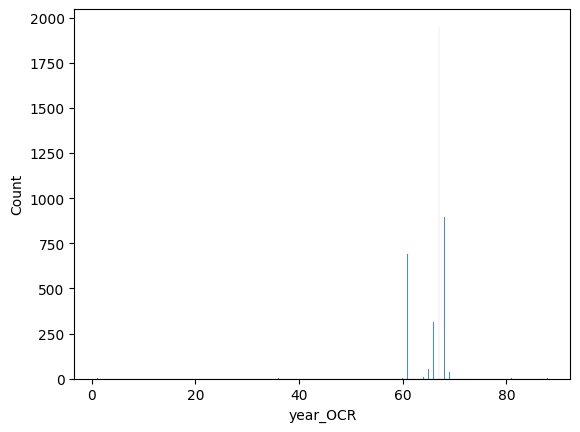

In [433]:
df_num2 = df_num2.copy(deep=True)
df_num2['year_OCR'] = df_num2['year_OCR'].astype('float')
sns.histplot(data=df_num2, x='year_OCR')

In [434]:
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x<62 else x)
df_num2['year_OCR'] = df_num2['year_OCR'].apply(lambda x: np.nan if x>80 else x)

In [435]:
df_num2['year'] = df_num2['year_OCR'] + 1900
df_num2[['year', 'year_OCR']].sample(10)

,year,year_OCR
9390,1967.0,67.0
13206,1968.0,68.0
13749,NaN,NaN
5843,1967.0,67.0
9722,1968.0,68.0
6029,1967.0,67.0
13730,1967.0,67.0
13104,1968.0,68.0
11316,NaN,NaN
9990,1967.0,67.0


day:

<Axes: xlabel='day_of_year_OCR', ylabel='Count'>

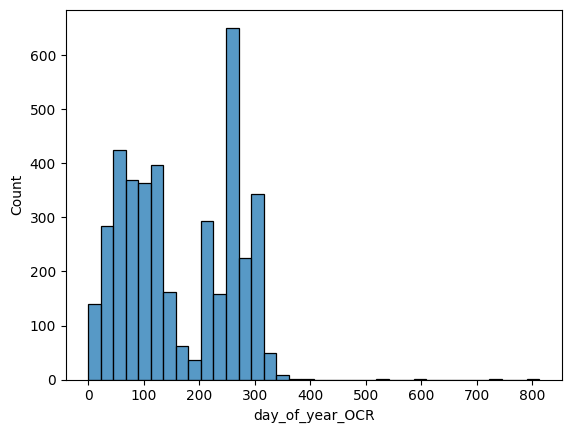

In [436]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].astype('float')
sns.histplot(data=df_num2, x='day_of_year_OCR')

In [437]:
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x>366 else x)
df_num2['day_of_year_OCR'] = df_num2['day_of_year_OCR'].apply(lambda x: np.nan if x==0 else x)
df_num2['day_of_year'] = df_num2['day_of_year_OCR']
df_num2[['day_of_year', 'day_of_year_OCR']].sample(10)

,day_of_year,day_of_year_OCR
11924,55.0,55.0
15086,134.0,134.0
4871,109.0,109.0
14017,177.0,177.0
10298,293.0,293.0
1047,215.0,215.0
14977,136.0,136.0
9364,306.0,306.0
6134,245.0,245.0
5757,266.0,266.0


hour:

<Axes: xlabel='hour_OCR', ylabel='Count'>

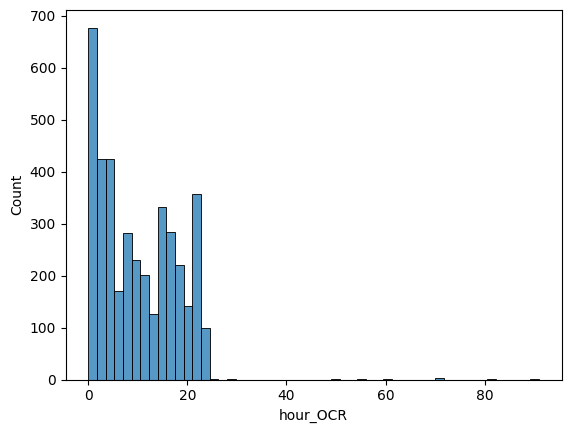

In [438]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].astype('float')
sns.histplot(data=df_num2, x='hour_OCR')

In [439]:
df_num2['hour_OCR'] = df_num2['hour_OCR'].apply(lambda x: np.nan if x>24 else x)
df_num2['hour'] = df_num2['hour_OCR']
df_num2[['hour', 'hour_OCR']].sample(10)

,hour,hour_OCR
16402,23.0,23.0
5575,1.0,1.0
14848,11.0,11.0
16461,11.0,11.0
1823,1.0,1.0
16383,10.0,10.0
11778,15.0,15.0
15133,11.0,11.0
17002,0.0,0.0
5702,20.0,20.0


minute:

<Axes: xlabel='minute_OCR', ylabel='Count'>

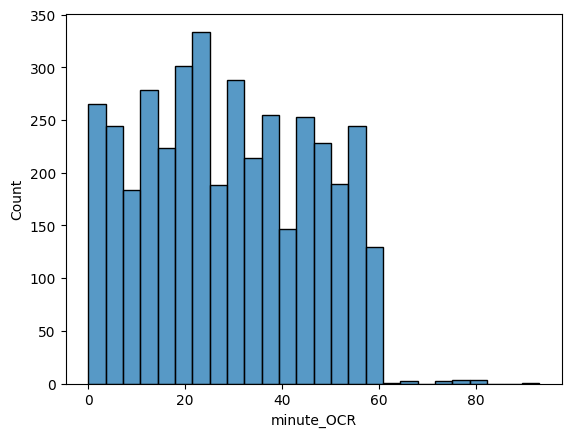

In [440]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].astype('float')
sns.histplot(data=df_num2, x='minute_OCR')

In [441]:
df_num2['minute_OCR'] = df_num2['minute_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['minute'] = df_num2['minute_OCR']
df_num2[['minute', 'minute_OCR']].sample(10)

,minute,minute_OCR
6379,31.0,31.0
13719,31.0,31.0
13728,9.0,9.0
9701,39.0,39.0
5603,31.0,31.0
14994,36.0,36.0
15822,22.0,22.0
13789,43.0,43.0
9983,16.0,16.0
1582,3.0,3.0


second:

<Axes: xlabel='second_OCR', ylabel='Count'>

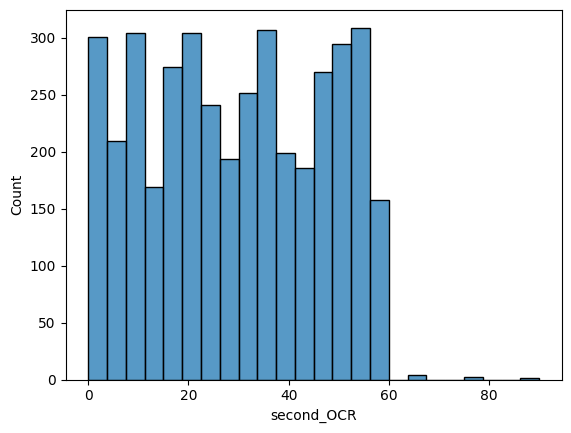

In [442]:
df_num2['second_OCR'] = df_num2['second_OCR'].astype('float')
sns.histplot(data=df_num2, x='second_OCR')

In [443]:
df_num2['second_OCR'] = df_num2['second_OCR'].apply(lambda x: np.nan if x>60 else x)
df_num2['second'] = df_num2['second_OCR']
df_num2[['second', 'second_OCR']].sample(10)

,second,second_OCR
15079,42.0,42.0
9440,23.0,23.0
5557,34.0,34.0
13683,34.0,34.0
16330,25.0,25.0
13892,2.0,2.0
9698,57.0,57.0
14910,58.0,58.0
5122,38.0,38.0
1925,35.0,35.0


construct timestamp:

In [444]:
df_num2 = construct_timestamp(df_in=df_num2)
print(len(df_num2))

3979


In [445]:
df_num2[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
17452,1966.0,01,13,13.0,15.0,47.0,1966-01-13 13:15:47,1
13374,1967.0,03,19,4.0,38.0,44.0,1967-03-19 04:38:44,1
9527,1967.0,10,19,10.0,58.0,49.0,1967-10-19 10:58:49,1
16597,1967.0,11,05,22.0,46.0,20.0,1967-11-05 22:46:20,1
1235,1968.0,08,20,2.0,21.0,29.0,1968-08-20 02:21:29,1
16566,1967.0,11,04,22.0,14.0,20.0,1967-11-04 22:14:20,1
16388,1967.0,11,06,10.0,41.0,22.0,1967-11-06 10:41:22,1
10797,1967.0,02,13,9.0,29.0,49.0,1967-02-13 09:29:49,1
9363,NaN,11,02,9.0,1.0,36.0,NaT,0
17034,1966.0,01,26,1.0,49.0,56.0,1966-01-26 01:49:56,1


#  

#### num - check timestamp components, construct timestamp:

In [446]:
df_num[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2
22760,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
23320,4.0,0.0,8.0,5.0,0.0,4.0,2.0,8.0,5.0,0.0
19712,2.0,3.0,6.0,2.0,2.0,3.0,6.0,2.0,1.0,1.0
22369,3.0,2.0,9.0,2.0,1.0,3.0,0.0,1.0,1.0,8.0
7685,2.0,2.0,2.0,2.0,2.0,2.0,4.0,0.0,4.0,2.0
21479,3.0,2.0,8.0,8.0,1.0,2.0,2.0,7.0,2.0,6.0
23989,3.0,2.0,1.0,2.0,1.0,3.0,0.0,8.0,3.0,0.0
19401,4.0,2.0,5.0,6.0,1.0,9.0,2.0,1.0,0.0,7.0
23701,4.0,0.0,5.0,5.0,0.0,1.0,3.0,8.0,2.0,2.0
23843,4.0,0.0,5.0,5.0,2.0,2.0,4.0,4.0,3.0,6.0


year - adjust to baseline 1962:

<Axes: xlabel='year', ylabel='Count'>

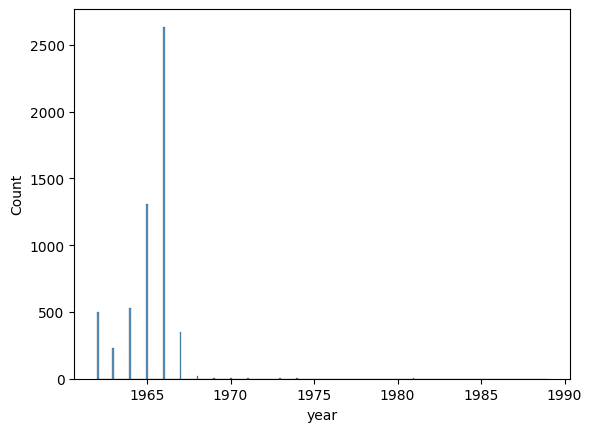

In [447]:
df_num = df_num.copy(deep=True)
df_num['year'] = df_num['year_1'] + 1962
df_num['year'] = df_num['year'].astype('float')
sns.histplot(data=df_num, x='year')

In [448]:
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x<1962 else x)
df_num['year'] = df_num['year'].apply(lambda x: np.nan if x>1980 else x)
df_num[['year', 'year_1']].sample(10)

,year,year_1
19584,1964.0,2.0
23573,1966.0,4.0
24561,1965.0,3.0
21806,1965.0,3.0
19558,1964.0,2.0
18527,1966.0,4.0
24065,1965.0,3.0
23626,1966.0,4.0
21525,1965.0,3.0
8298,1964.0,2.0


day:

<Axes: xlabel='day_1', ylabel='Count'>

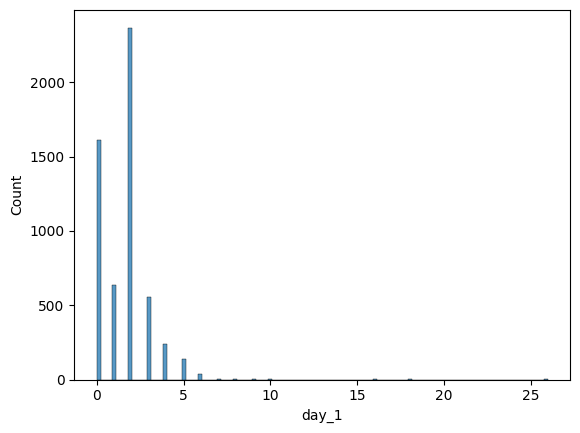

In [449]:
df_num['day_1'] = df_num['day_1'].astype(int)
sns.histplot(data=df_num, x='day_1')

In [450]:
df_num['day_1'] = df_num['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

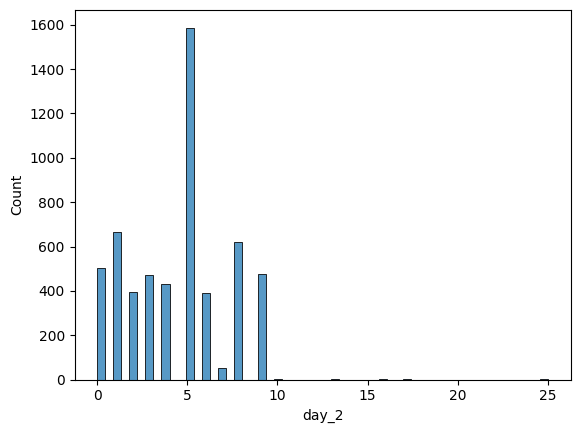

In [451]:
df_num['day_2'] = df_num['day_2'].astype(int)
sns.histplot(data=df_num, x='day_2')

In [452]:
df_num['day_2'] = df_num['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

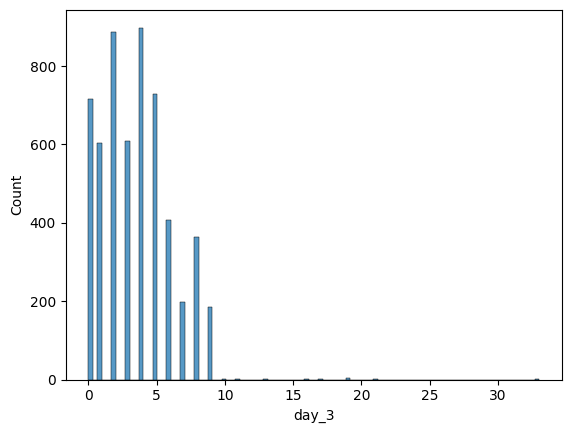

In [453]:
df_num['day_3'] = df_num['day_3'].astype(int)
sns.histplot(data=df_num, x='day_3')

In [454]:
df_num['day_3'] = df_num['day_3'].apply(lambda x: np.nan if x>9 else x)

In [455]:
df_num_daycheck = df_num[~pd.isna(df_num['day_1'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_2'])]
df_num_daycheck = df_num_daycheck[~pd.isna(df_num_daycheck['day_3'])]
df_num_daycheck['day_of_year'] = df_num_daycheck['day_1'].astype(int).astype(str) + df_num_daycheck['day_2'].astype(int).astype(str) + df_num_daycheck['day_3'].astype(int).astype(str)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].astype(int)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_num_daycheck['day_of_year'] = df_num_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_num_nullday = df_num.loc[pd.isna(df_num['day_1']) | pd.isna(df_num['day_2']) | pd.isna(df_num['day_3'])]
df_num_nullday = df_num_nullday.copy(deep=True)
df_num_nullday['day_of_year'] = np.nan
df_num = pd.concat([df_num_daycheck, df_num_nullday])
print(len(df_num))
df_num[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

5604


,day_of_year,day_1,day_2,day_3
23016,53.0,0.0,5.0,3.0
18373,137.0,1.0,3.0,7.0
19332,256.0,2.0,5.0,6.0
22403,152.0,1.0,5.0,2.0
20751,250.0,2.0,5.0,0.0
22878,51.0,0.0,5.0,1.0
19365,256.0,2.0,5.0,6.0
20918,234.0,2.0,3.0,4.0
20598,NaN,4.0,2.0,5.0
24541,304.0,3.0,0.0,4.0


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

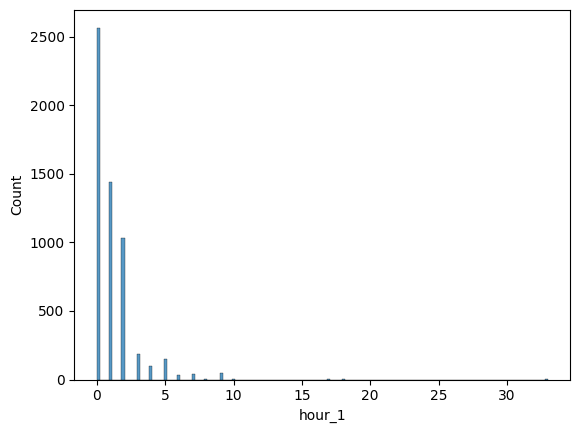

In [456]:
df_num['hour_1'] = df_num['hour_1'].astype(int)
sns.histplot(data=df_num, x='hour_1')

In [457]:
df_num['hour_1'] = df_num['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

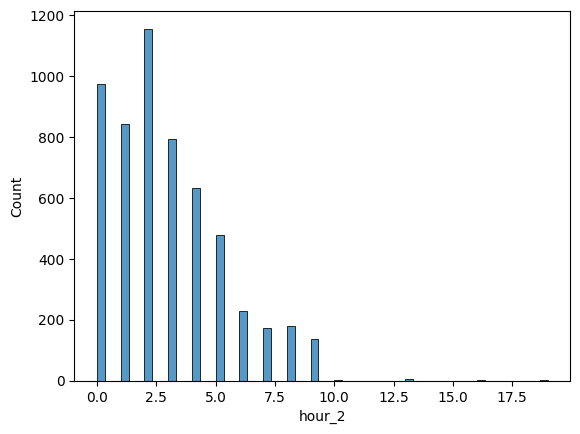

In [458]:
df_num['hour_2'] = df_num['hour_2'].astype(int)
sns.histplot(data=df_num, x='hour_2')

In [459]:
df_num['hour_2'] = df_num['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [460]:
df_num_hourcheck = df_num[~pd.isna(df_num['hour_1'])]
df_num_hourcheck = df_num_hourcheck[~pd.isna(df_num_hourcheck['hour_2'])]
df_num_hourcheck['hour'] = df_num_hourcheck['hour_1'].astype(int).astype(str) + df_num_hourcheck['hour_2'].astype(int).astype(str)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].astype(int)
df_num_hourcheck['hour'] = df_num_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_num_nullhour = df_num.loc[pd.isna(df_num['hour_1']) | pd.isna(df_num['hour_2'])]
df_num_nullhour = df_num_nullhour.copy(deep=True)
df_num_nullhour['hour'] = np.nan
df_num = pd.concat([df_num_hourcheck, df_num_nullhour])
print(len(df_num))
df_num[['hour', 'hour_1', 'hour_2']].sample(10)

5604


,hour,hour_1,hour_2
22575,0.0,0.0,0.0
22282,14.0,1.0,4.0
24483,2.0,0.0,2.0
20389,2.0,0.0,2.0
18700,12.0,1.0,2.0
19951,NaN,4.0,3.0
18377,3.0,0.0,3.0
20264,2.0,0.0,2.0
23356,6.0,0.0,6.0
23602,6.0,0.0,6.0


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

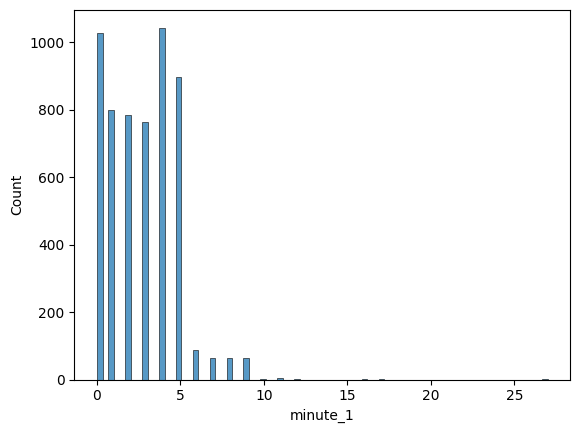

In [461]:
df_num['minute_1'] = df_num['minute_1'].astype(int)
sns.histplot(data=df_num, x='minute_1')

In [462]:
df_num['minute_1'] = df_num['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

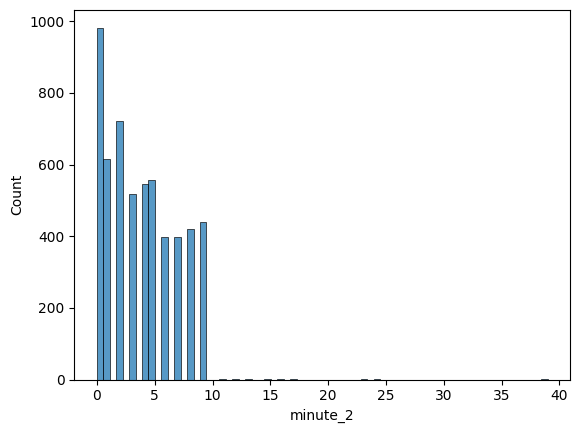

In [463]:
df_num['minute_2'] = df_num['minute_2'].astype(int)
sns.histplot(data=df_num, x='minute_2')

In [464]:
df_num['minute_2'] = df_num['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [465]:
df_num_mincheck = df_num[~pd.isna(df_num['minute_1'])]
df_num_mincheck = df_num_mincheck[~pd.isna(df_num_mincheck['minute_2'])]
df_num_mincheck['minute'] = df_num_mincheck['minute_1'].astype(int).astype(str) + df_num_mincheck['minute_2'].astype(int).astype(str)
df_num_mincheck['minute'] = df_num_mincheck['minute'].astype(int)
df_num_mincheck['minute'] = df_num_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_num_nullmin = df_num.loc[pd.isna(df_num['minute_1']) | pd.isna(df_num['minute_2'])]
df_num_nullmin = df_num_nullmin.copy(deep=True)
df_num_nullmin['minute'] = np.nan
df_num = pd.concat([df_num_mincheck, df_num_nullmin])
print(len(df_num))
df_num[['minute', 'minute_1', 'minute_2']].sample(10)

5604


,minute,minute_1,minute_2
24108,45.0,4.0,5.0
23285,5.0,0.0,5.0
21641,59.0,5.0,9.0
24210,9.0,0.0,9.0
24568,46.0,4.0,6.0
18897,13.0,1.0,3.0
22840,39.0,3.0,9.0
21535,14.0,1.0,4.0
23021,46.0,4.0,6.0
23761,NaN,8.0,3.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

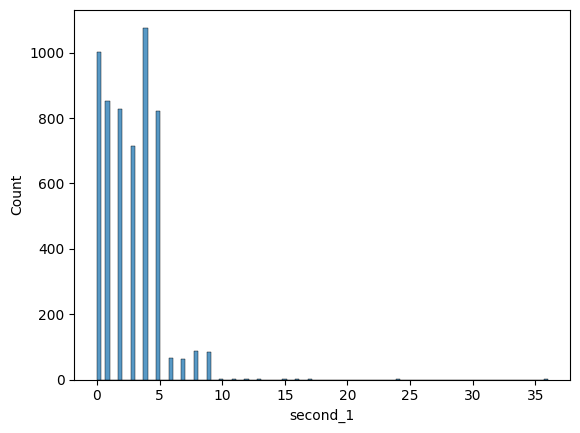

In [466]:
df_num['second_1'] = df_num['second_1'].astype(int)
sns.histplot(data=df_num, x='second_1')

In [467]:
df_num['second_1'] = df_num['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

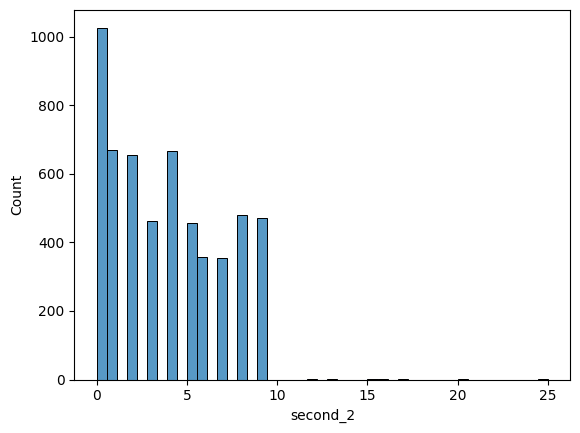

In [468]:
df_num['second_2'] = df_num['second_2'].astype(int)
sns.histplot(data=df_num, x='second_2')

In [469]:
df_num['second_2'] = df_num['second_2'].apply(lambda x: np.nan if x>9 else x)

In [470]:
df_num_seccheck = df_num[~pd.isna(df_num['second_1'])]
df_num_seccheck = df_num_seccheck[~pd.isna(df_num_seccheck['second_2'])]
df_num_seccheck['second'] = df_num_seccheck['second_1'].astype(int).astype(str) + df_num_seccheck['second_2'].astype(int).astype(str)
df_num_seccheck['second'] = df_num_seccheck['second'].astype(int)
df_num_seccheck['second'] = df_num_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_num_nullsec = df_num.loc[pd.isna(df_num['second_1']) | pd.isna(df_num['second_2'])]
df_num_nullsec = df_num_nullsec.copy(deep=True)
df_num_nullsec['second'] = np.nan
df_num = pd.concat([df_num_seccheck, df_num_nullsec])
print(len(df_num))
df_num[['second', 'second_1', 'second_2']].sample(10)

5604


,second,second_1,second_2
24597,24.0,2.0,4.0
23223,16.0,1.0,6.0
23022,41.0,4.0,1.0
19357,7.0,0.0,7.0
19369,36.0,3.0,6.0
19570,NaN,7.0,1.0
22507,27.0,2.0,7.0
18611,44.0,4.0,4.0
23236,46.0,4.0,6.0
19935,NaN,8.0,0.0


construct timestamp:

In [471]:
df_num = construct_timestamp(df_in=df_num)
print(len(df_num))

5604


In [472]:
df_num[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
7834,1964.0,08,10,22.0,22.0,24.0,1964-08-10 22:22:24,1
19651,1968.0,05,18,22.0,46.0,39.0,1968-05-18 22:46:39,1
23449,1966.0,03,26,23.0,40.0,15.0,1966-03-26 23:40:15,1
20640,1966.0,09,11,17.0,31.0,21.0,1966-09-11 17:31:21,1
20531,1966.0,09,09,18.0,2.0,24.0,1966-09-09 18:02:24,1
18829,1963.0,NaN,NaN,1.0,40.0,NaN,NaT,0
18764,1966.0,06,15,17.0,57.0,25.0,1966-06-15 17:57:25,1
23313,1963.0,NaN,NaN,NaN,5.0,NaN,NaT,0
18821,1966.0,06,15,19.0,49.0,29.0,1966-06-15 19:49:29,1
23562,1966.0,03,25,23.0,0.0,49.0,1966-03-25 23:00:49,1


#  

#### dot - check timestamp components, construct timestamp:

In [473]:
df_dot = df_dot.copy(deep=True)
df_dot[['year_1', 'day_1', 'day_2', 'day_3', 'hour_1', 'hour_2', 'minute_1', 'minute_2', 'second_1', 'second_2', 'is_dot']].sample(10)

,year_1,day_1,day_2,day_3,hour_1,hour_2,minute_1,minute_2,second_1,second_2,is_dot
21896,NaN,1.0,8.0,8.0,0.0,10.0,0.0,8.0,8.0,8.0,NaN
21874,NaN,1.0,16.0,8.0,16.0,16.0,9.0,0.0,16.0,4.0,NaN
21126,NaN,1.0,4.0,4.0,12.0,4.0,1.0,9.0,8.0,0.0,NaN
21947,NaN,1.0,8.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,NaN
22071,NaN,1.0,8.0,8.0,8.0,9.0,9.0,0.0,8.0,8.0,NaN
21274,NaN,2.0,16.0,8.0,17.0,0.0,8.0,8.0,16.0,8.0,NaN
21347,NaN,1.0,8.0,8.0,16.0,0.0,8.0,17.0,0.0,9.0,NaN
21186,NaN,1.0,16.0,8.0,25.0,0.0,1.0,17.0,0.0,0.0,NaN
21999,NaN,1.0,16.0,8.0,8.0,8.0,9.0,8.0,8.0,1.0,NaN
21911,NaN,1.0,8.0,8.0,8.0,10.0,0.0,1.0,8.0,8.0,NaN


day:

<Axes: xlabel='day_1', ylabel='Count'>

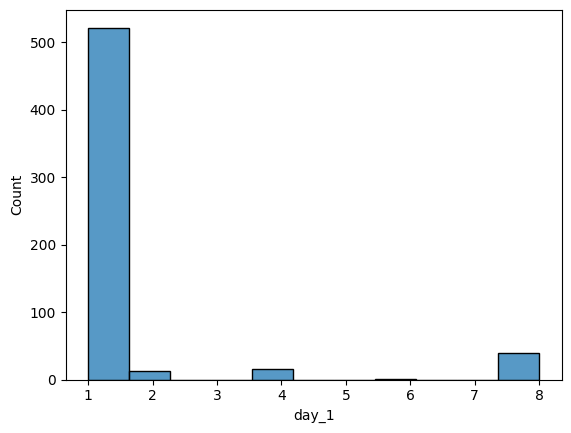

In [474]:
df_dot['day_1'] = df_dot['day_1'].astype(int)
sns.histplot(data=df_dot, x='day_1')

In [475]:
df_dot['day_1'] = df_dot['day_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_2', ylabel='Count'>

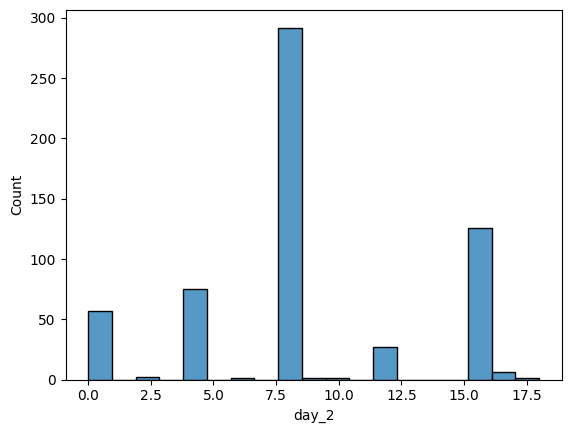

In [476]:
df_dot['day_2'] = df_dot['day_2'].astype(int)
sns.histplot(data=df_dot, x='day_2')

In [477]:
df_dot['day_2'] = df_dot['day_2'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='day_3', ylabel='Count'>

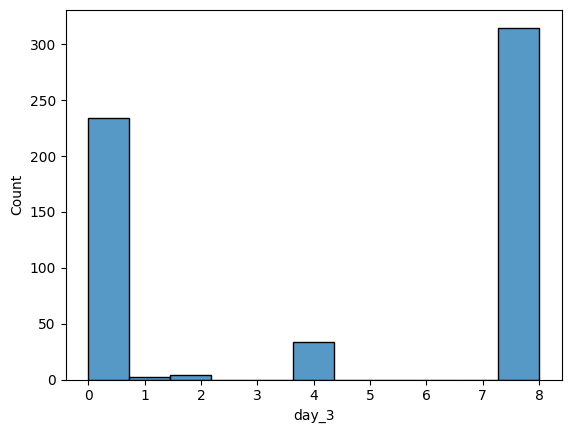

In [478]:
df_dot['day_3'] = df_dot['day_3'].astype(int)
sns.histplot(data=df_dot, x='day_3')

In [479]:
df_dot['day_3'] = df_dot['day_3'].apply(lambda x: np.nan if x>9 else x)

In [480]:
df_dot_daycheck = df_dot[~pd.isna(df_dot['day_1'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_2'])]
df_dot_daycheck = df_dot_daycheck[~pd.isna(df_dot_daycheck['day_3'])]
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_1'].astype(int).astype(str) + df_dot_daycheck['day_2'].astype(int).astype(str) + df_dot_daycheck['day_3'].astype(int).astype(str)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].astype(int)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x>366 else x)
df_dot_daycheck['day_of_year'] = df_dot_daycheck['day_of_year'].apply(lambda x: np.nan if x==0 else x)
df_dot_nullday = df_dot.loc[pd.isna(df_dot['day_1']) | pd.isna(df_dot['day_2']) | pd.isna(df_dot['day_3'])]
df_dot_nullday = df_dot_nullday.copy(deep=True)
df_dot_nullday['day_of_year'] = np.nan
df_dot = pd.concat([df_dot_daycheck, df_dot_nullday])
print(len(df_dot))
df_dot[['day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

589


,day_of_year,day_1,day_2,day_3
21273,NaN,1,NaN,4
21168,188.0,1,8.0,8
21996,NaN,1,NaN,8
21130,148.0,1,4.0,8
22079,188.0,1,8.0,8
21940,180.0,1,8.0,0
21314,180.0,1,8.0,0
21227,140.0,1,4.0,0
22031,NaN,1,NaN,8
21206,NaN,4,0.0,0


year - infer from day:

In [481]:
df_dot['year'] = np.nan
for i in range(0, len(df_dot)):
    day = df_dot['day_of_year'].iloc[i]
    if (day < 366) & (day > 0):
        if day > 271:
            df_dot['year'].iloc[i] = 1962
        else:
            df_dot['year'].iloc[i] = 1963
df_dot[['year', 'day_of_year', 'day_1', 'day_2', 'day_3']].sample(10)

C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_22416\2722169012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1963
C:\Users\rnaidoo\AppData\Local\Temp\ipykernel_22416\2722169012.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dot['year'].iloc[i] = 1962


,year,day_of_year,day_1,day_2,day_3
21244,1963.0,180.0,1,8.0,0
21986,NaN,NaN,1,NaN,8
21233,1963.0,188.0,1,8.0,8
21958,1963.0,180.0,1,8.0,0
21099,NaN,NaN,4,0.0,0
21951,1963.0,180.0,1,8.0,0
21115,1963.0,188.0,1,8.0,8
21871,1963.0,188.0,1,8.0,8
21864,1963.0,188.0,1,8.0,8
21340,NaN,NaN,1,NaN,8


hour:

<Axes: xlabel='hour_1', ylabel='Count'>

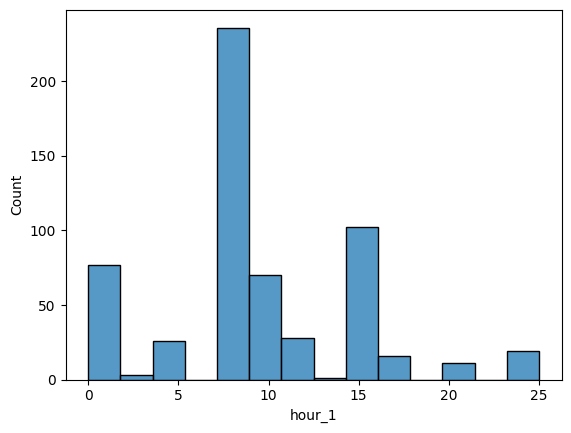

In [482]:
df_dot['hour_1'] = df_dot['hour_1'].astype(int)
sns.histplot(data=df_dot, x='hour_1')

In [483]:
df_dot['hour_1'] = df_dot['hour_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='hour_2', ylabel='Count'>

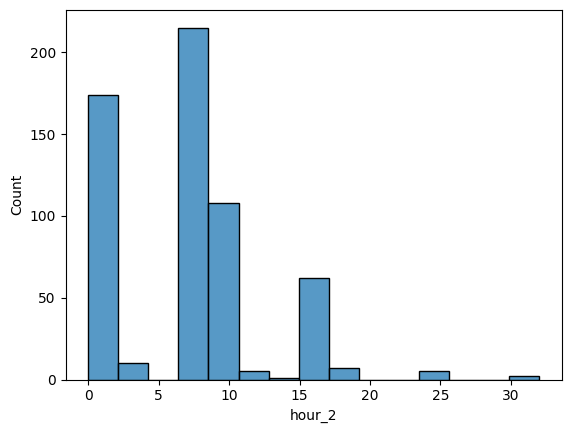

In [484]:
df_dot['hour_2'] = df_dot['hour_2'].astype(int)
sns.histplot(data=df_dot, x='hour_2')

In [485]:
df_dot['hour_2'] = df_dot['hour_2'].apply(lambda x: np.nan if x>9 else x)

In [486]:
df_dot_hourcheck = df_dot[~pd.isna(df_dot['hour_1'])]
df_dot_hourcheck = df_dot_hourcheck[~pd.isna(df_dot_hourcheck['hour_2'])]
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour_1'].astype(int).astype(str) + df_dot_hourcheck['hour_2'].astype(int).astype(str)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].astype(int)
df_dot_hourcheck['hour'] = df_dot_hourcheck['hour'].apply(lambda x: np.nan if x>23 else x)
df_dot_nullhour = df_dot.loc[pd.isna(df_dot['hour_1']) | pd.isna(df_dot['hour_2'])]
df_dot_nullhour = df_dot_nullhour.copy(deep=True)
df_dot_nullhour['hour'] = np.nan
df_dot = pd.concat([df_dot_hourcheck, df_dot_nullhour])
print(len(df_dot))
df_dot[['hour', 'hour_1', 'hour_2']].sample(10)

589


,hour,hour_1,hour_2
22082,NaN,NaN,0.0
21282,NaN,9.0,8.0
21353,NaN,NaN,0.0
22100,NaN,NaN,9.0
21340,NaN,8.0,NaN
21095,NaN,4.0,8.0
21232,NaN,9.0,8.0
21861,NaN,8.0,8.0
21351,NaN,NaN,0.0
21298,NaN,NaN,NaN


minute:

<Axes: xlabel='minute_1', ylabel='Count'>

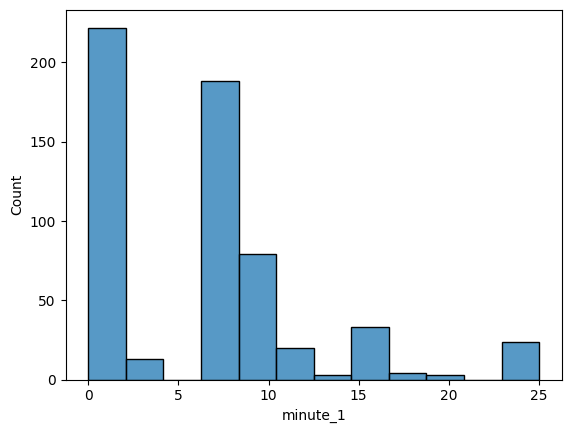

In [487]:
df_dot['minute_1'] = df_dot['minute_1'].astype(int)
sns.histplot(data=df_dot, x='minute_1')

In [488]:
df_dot['minute_1'] = df_dot['minute_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='minute_2', ylabel='Count'>

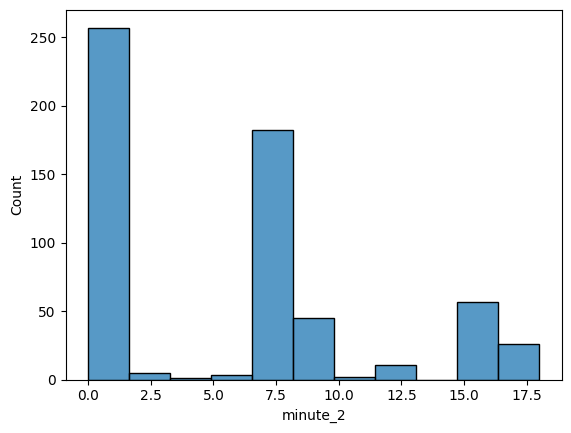

In [489]:
df_dot['minute_2'] = df_dot['minute_2'].astype(int)
sns.histplot(data=df_dot, x='minute_2')

In [490]:
df_dot['minute_2'] = df_dot['minute_2'].apply(lambda x: np.nan if x>9 else x)

In [491]:
df_dot_mincheck = df_dot[~pd.isna(df_dot['minute_1'])]
df_dot_mincheck = df_dot_mincheck[~pd.isna(df_dot_mincheck['minute_2'])]
df_dot_mincheck['minute'] = df_dot_mincheck['minute_1'].astype(int).astype(str) + df_dot_mincheck['minute_2'].astype(int).astype(str)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].astype(int)
df_dot_mincheck['minute'] = df_dot_mincheck['minute'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullmin = df_dot.loc[pd.isna(df_dot['minute_1']) | pd.isna(df_dot['minute_2'])]
df_dot_nullmin = df_dot_nullmin.copy(deep=True)
df_dot_nullmin['minute'] = np.nan
df_dot = pd.concat([df_dot_mincheck, df_dot_nullmin])
print(len(df_dot))
df_dot[['minute', 'minute_1', 'minute_2']].sample(10)

589


,minute,minute_1,minute_2
21934,NaN,8.0,9.0
21971,18.0,1.0,8.0
22122,NaN,NaN,0.0
21141,NaN,NaN,0.0
21393,8.0,0.0,8.0
21890,0.0,0.0,0.0
21287,NaN,8.0,8.0
21313,NaN,NaN,8.0
21354,NaN,8.0,1.0
22037,NaN,8.0,9.0


second:

<Axes: xlabel='second_1', ylabel='Count'>

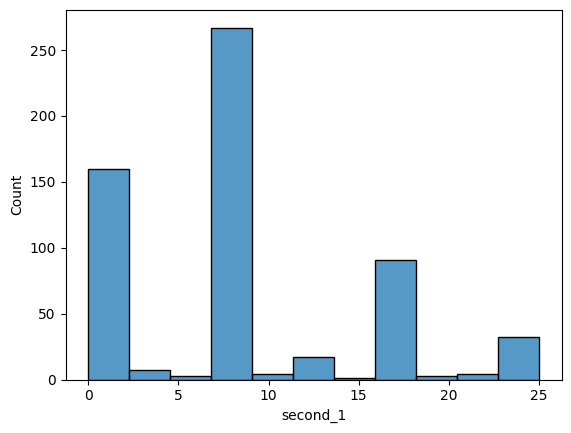

In [492]:
df_dot['second_1'] = df_dot['second_1'].astype(int)
sns.histplot(data=df_dot, x='second_1')

In [493]:
df_dot['second_1'] = df_dot['second_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='second_2', ylabel='Count'>

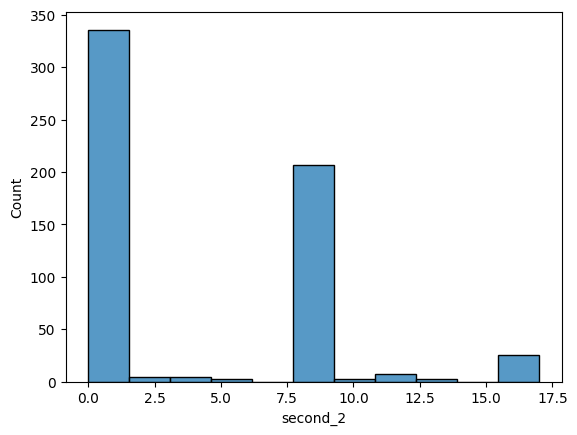

In [494]:
df_dot['second_2'] = df_dot['second_2'].astype(int)
sns.histplot(data=df_dot, x='second_2')

In [495]:
df_dot['second_2'] = df_dot['second_2'].apply(lambda x: np.nan if x>9 else x)

In [496]:
df_dot_seccheck = df_dot[~pd.isna(df_dot['second_1'])]
df_dot_seccheck = df_dot_seccheck[~pd.isna(df_dot_seccheck['second_2'])]
df_dot_seccheck['second'] = df_dot_seccheck['second_1'].astype(int).astype(str) + df_dot_seccheck['second_2'].astype(int).astype(str)
df_dot_seccheck['second'] = df_dot_seccheck['second'].astype(int)
df_dot_seccheck['second'] = df_dot_seccheck['second'].apply(lambda x: np.nan if x>59 else x)
df_dot_nullsec = df_dot.loc[pd.isna(df_dot['second_1']) | pd.isna(df_dot['second_2'])]
df_dot_nullsec = df_dot_nullsec.copy(deep=True)
df_dot_nullsec['second'] = np.nan
df_dot = pd.concat([df_dot_seccheck, df_dot_nullsec])
print(len(df_dot))
df_dot[['second', 'second_1', 'second_2']].sample(10)

589


,second,second_1,second_2
22059,NaN,NaN,NaN
21314,NaN,8.0,0.0
21891,10.0,1.0,0.0
21894,NaN,8.0,0.0
21391,18.0,1.0,8.0
21093,NaN,NaN,0.0
22054,NaN,8.0,0.0
22072,NaN,9.0,0.0
21187,0.0,0.0,0.0
21983,NaN,9.0,1.0


construct timestamp:

In [497]:
df_dot = construct_timestamp(df_in=df_dot)
print(len(df_dot))

589


In [498]:
df_dot[['year', 'month', 'day', 'hour', 'minute', 'second', 'Timestamp', 'time_quality']].sample(10)

,year,month,day,hour,minute,second,Timestamp,time_quality
21979,1963.0,07,07,NaN,NaN,NaN,1963-07-07 00:00:00,4
21875,NaN,NaN,NaN,NaN,10.0,NaN,NaT,0
21343,NaN,NaN,NaN,NaN,NaN,1.0,NaT,0
21349,1963.0,07,07,NaN,NaN,18.0,1963-07-07 00:00:00,4
22030,1963.0,06,29,18.0,NaN,NaN,1963-06-29 18:00:00,3
21288,NaN,NaN,NaN,NaN,NaN,NaN,NaT,0
21178,1963.0,06,29,NaN,NaN,11.0,1963-06-29 00:00:00,4
22027,NaN,NaN,NaN,NaN,1.0,NaN,NaT,0
21864,1963.0,07,07,NaN,NaN,NaN,1963-07-07 00:00:00,4
21269,NaN,NaN,NaN,NaN,NaN,0.0,NaT,0


#  

#### Check station number:

num2:

<Axes: xlabel='station_number_OCR', ylabel='Count'>

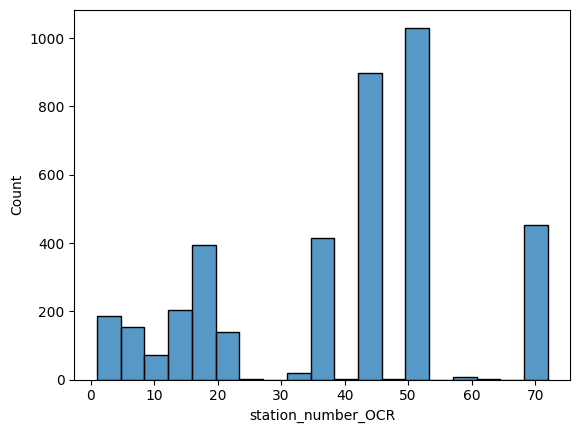

In [499]:
df_num2['station_number_OCR'] = df_num2['station_number_OCR'].astype('float')
sns.histplot(data=df_num2, x='station_number_OCR')

In [500]:
df_num2['station_number'] = df_num2['station_number_OCR']
df_num2[['station_number', 'station_number_OCR']].sample(10)

,station_number,station_number_OCR
8918,43.0,43.0
5203,69.0,69.0
12915,43.0,43.0
13388,19.0,19.0
12703,43.0,43.0
12173,72.0,72.0
10167,8.0,8.0
11468,43.0,43.0
16342,50.0,50.0
14726,50.0,50.0


num:

<Axes: xlabel='station_number_1', ylabel='Count'>

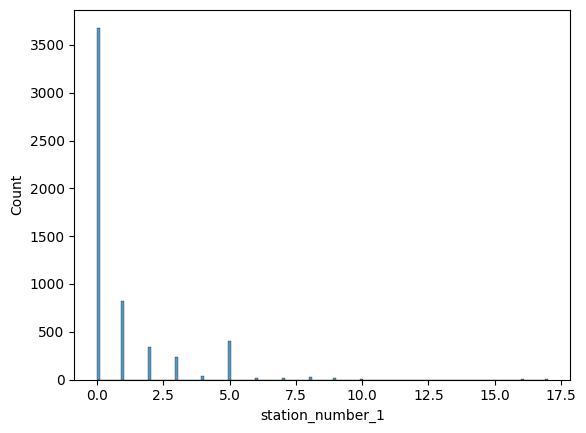

In [501]:
df_num['station_number_1'] = df_num['station_number_1'].astype(int)
sns.histplot(data=df_num, x='station_number_1')

In [502]:
df_num['station_number_1'] = df_num['station_number_1'].apply(lambda x: np.nan if x>9 else x)

<Axes: xlabel='station_number_2', ylabel='Count'>

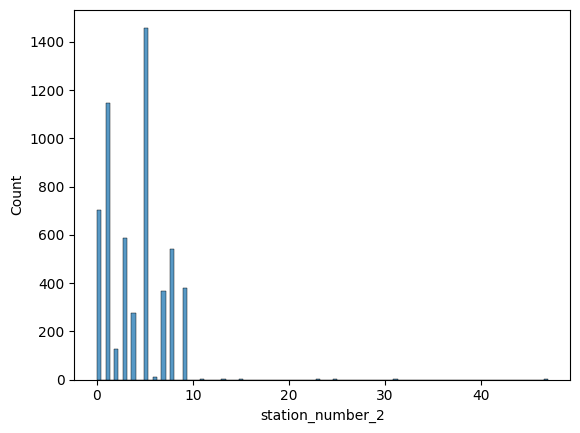

In [503]:
df_num['station_number_2'] = df_num['station_number_2'].astype(int)
sns.histplot(data=df_num, x='station_number_2')

In [504]:
df_num['station_number_2'] = df_num['station_number_2'].apply(lambda x: np.nan if x>9 else x)

In [505]:
df_num_stncheck = df_num[~pd.isna(df_num['station_number_1'])]
df_num_stncheck = df_num_stncheck[~pd.isna(df_num_stncheck['station_number_2'])]
df_num_stncheck['station_number'] = df_num_stncheck['station_number_1'].astype(int).astype(str) + df_num_stncheck['station_number_2'].astype(int).astype(str)
df_num_stncheck['station_number'] = df_num_stncheck['station_number'].astype(int)
df_num_nullstn = df_num.loc[pd.isna(df_num['station_number_1']) | pd.isna(df_num['station_number_2'])]
df_num_nullstn = df_num_nullstn.copy(deep=True)
df_num_nullstn['station_number'] = np.nan
df_num = pd.concat([df_num_stncheck, df_num_nullstn])
print(len(df_num))
df_num[['station_number', 'station_number_1', 'station_number_2']].sample(10)

5604


,station_number,station_number_1,station_number_2
22965,1.0,0.0,1.0
24031,13.0,1.0,3.0
20358,5.0,0.0,5.0
23014,1.0,0.0,1.0
20624,8.0,0.0,8.0
20070,50.0,5.0,0.0
23382,95.0,9.0,5.0
19594,30.0,3.0,0.0
20429,5.0,0.0,5.0
22211,7.0,0.0,7.0


dot:

In [506]:
df_dot[['station_number']].sample(10)

,station_number
21255,1.0
21319,1.0
21296,1.0
21974,8.0
21198,5.0
22056,8.0
21087,25.0
22020,16.0
22015,16.0
21242,1.0


#  

#### Recombine results:

In [507]:
df_result2 = pd.concat([df_num2, df_num, df_dot, df_outlier, df_loss])
print(len(df_result2))
df_result2.sample(10)

25250


,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,station_number,station_number_1,station_number_2,year_1,...,year,day_of_year,hour,minute,second,time_quality,month_day,month,day,Timestamp
2145,R014207810,5119,118.png,loss,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5161,R014207817,4170-03A,68.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
12792,R014207834,4491-43A,85.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
21892,R014207961,1060-A,140.png,dot,1.608871,1446.000000,8.0,NaN,NaN,NaN,...,1963.0,180.0,NaN,0.0,NaN,4.0,06-29,06,29,1963-06-29
16628,R014207843,3194-14A,108.png,loss,1.705645,1208.163265,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
9851,R014207828,4416-37,79.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
5987,R014207818,4245-38A,236.png,num2,1.500000,1230.303030,38.0,NaN,NaN,NaN,...,NaN,254.0,6.0,43.0,53.0,0.0,09-11,09,11,NaT
11663,R014207833,4331-12,248.png,loss,4.066038,192.307692,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
22116,R014207961,1060-A,79.png,dot,1.500000,1396.000000,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaT
285,R014207711,39,54.png,outlier,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


#  

#### Retrieve station details:

In [508]:
df_stn_nums = pd.read_excel(logDir + 'station_number_changes.xlsx')
df_stn_nums.head()

,Station_Number,Station_Code,Station_Name,Start_Date,Notes
0,1,RES,"Resolute Bay, NT, Canada",1962-09-29,Assumed start date at launch.
1,1,BPT,"Blossom Point, MD, USA",1965-07-01,NaN
2,2,PRI,"Prince Albert, SK, Canada",1962-09-29,Assumed start date at launch.
3,3,OTT,"Ottawa, Canada",1962-09-29,Assumed start date at launch.
4,3,FTM,"Fort Myers, FL, USA",1965-07-01,NaN


In [509]:
change_dates = df_stn_nums['Start_Date'].drop_duplicates().sort_values().reset_index(drop=True)
stn_nums = df_stn_nums['Station_Number'].unique()

In [510]:
df_result3 = pd.DataFrame()
for i in range(0, len(change_dates)):
    #Before the first change date - Assume there are no station numbers before launch
    if i == 0:
        print(change_dates[i])
        df_part = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))
    
    elif i > 0:
        print(change_dates[i])
        df_part_ = df_result2.loc[df_result2['Timestamp'] < change_dates[i]]
        df_part_ = df_part_.loc[df_part_['Timestamp'] >= change_dates[i-1]]
        
        df_sns = pd.DataFrame()
        for sn in stn_nums:
            df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
            df_sn = df_sn.loc[df_sn['Start_Date'] < change_dates[i]]
            if len(df_sn) > 1:
                df_sn = df_sn.sort_values('Start_Date', ascending=False)
                df_sn = df_sn.iloc[:1]
            df_sns = pd.concat([df_sns, df_sn])
        
        df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
        df_result3 = pd.concat([df_result3, df_part])
        print(len(df_result3))

#After last change date
last_change_date = change_dates[len(change_dates)-1]
print('After ' + str(last_change_date))
df_part_ = df_result2.loc[df_result2['Timestamp'] > last_change_date]

df_sns = pd.DataFrame()
for sn in stn_nums:
    df_sn = df_stn_nums.loc[df_stn_nums['Station_Number'] == sn]
    if len(df_sn) > 1:
        df_sn = df_sn.sort_values('Start_Date', ascending=False)
        df_sn = df_sn.iloc[:1]
    df_sns = pd.concat([df_sns, df_sn])

df_part = df_part_.merge(df_sns[['Station_Number', 'Station_Code']], how='left', left_on='station_number', right_on='Station_Number')
df_result3 = pd.concat([df_result3, df_part])
print(len(df_result3))

1962-09-29 00:00:00
89
1963-04-25 00:00:00
268
1963-08-06 00:00:00
637
1965-07-01 00:00:00
1086
After 1965-07-01 00:00:00
8555


In [511]:
df_stns = pd.read_csv(logDir + 'ground_stations.csv')
df_stns.head()

,Station_Code,Station_Name,Lat,Lng,Notes
0,ANT,"Antofagasta, Chile",23.6S,70.3W,NaN
1,BAT,"Byrd Station, Antarctica",80S,119.3W,Ref: https://en.wikipedia.org/wiki/Byrd_Station
2,BFR,"Bretigny, France",48.4N,2.2 E,Ref: https://en.wikipedia.org/wiki/Br%C3%A9tig...
3,BLR,"Boulder, CO, USA",40.1N,105.1W,NaN
4,BPT,"Blossom Point, MD, USA",38.4N,77.1W,NaN


In [512]:
df_result4 = df_result3.merge(df_stns[['Station_Code', 'Station_Name', 'Lat', 'Lng']], how='left', on='Station_Code')
print(len(df_result4))
df_result4[['Station_Number', 'Timestamp', 'Station_Code', 'Station_Name', 'Lat', 'Lng']].sample(10)

8555


,Station_Number,Timestamp,Station_Code,Station_Name,Lat,Lng
1596,69.0,1967-08-03 18:53:20,TRO,"Tromso, Norway",69.7N,18.9E
4220,43.0,1966-01-15 01:26:30,RES,"Resolute Bay, NT, Canada",74.7N,95W
2663,43.0,1967-02-22 04:32:18,RES,"Resolute Bay, NT, Canada",74.7N,95W
4701,5.0,1966-06-15 19:45:25,QUI,"Quito, Ecuador",0.6S,78.6W
5075,1.0,1966-09-13 01:54:01,BPT,"Blossom Point, MD, USA",38.4N,77.1W
2074,13.0,1966-12-10 20:19:51,COL,"College, Fairbanks, AK, USA",64.9N,147.8W
6690,7.0,1965-10-21 23:50:34,QUI,"Quito, Ecuador",0.6S,78.6W
7160,1.0,1966-02-22 05:44:21,BPT,"Blossom Point, MD, USA",38.4N,77.1W
4525,18.0,1966-05-17 05:01:18,WOO,"Woomera, Australia",31.1S,136.8E
7649,1.0,1966-02-23 22:03:28,BPT,"Blossom Point, MD, USA",38.4N,77.1W


#  

#### Save:

In [513]:
df_result5 = df_result4[['Directory', 'Subdirectory', 'filename', 'processed_image_class', 'fmin', 'max_depth', 'Timestamp',
                         'time_quality', 'Station_Number', 'Station_Code', 'Station_Name', 'Lat', 'Lng']]
df_result5.sample(10)

,Directory,Subdirectory,filename,processed_image_class,fmin,max_depth,Timestamp,time_quality,Station_Number,Station_Code,Station_Name,Lat,Lng
4266,R014207843,3237-43A,96.png,num2,1.512097,634.782609,1966-01-14 06:56:08,1.0,43.0,RES,"Resolute Bay, NT, Canada",74.7N,95W
5737,R014207950,2507-8-A,28.png,num,1.629032,1482.000000,1966-09-06 18:03:02,1.0,8.0,SNT,"Santiago, Chile",33.2S,70.1W
1242,R014207808,4612-50,200.png,num2,1.500000,1006.000000,1968-10-21 00:24:17,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
7132,R014207963,1546-1B,156.png,num,1.544355,388.000000,1966-02-22 03:58:14,1.0,1.0,BPT,"Blossom Point, MD, USA",38.4N,77.1W
1759,R014207818,4228-43A,313.png,num2,1.733871,1370.588235,1967-09-26 01:24:26,1.0,43.0,RES,"Resolute Bay, NT, Canada",74.7N,95W
2146,R014207828,4413-21A,167.png,num2,1.504032,1797.058824,1967-11-06 08:06:14,1.0,21.0,RAL,"Orroral Valley, Australia",35.6S,149E
3837,R014207839,4130-50A,183.png,num2,1.500000,1187.500000,1967-09-19 04:13:16,1.0,50.0,OTT,"Ottawa, Canada",45.4N,75.7W
3110,R014207834,4493-43,101.png,num2,1.528226,1950.000000,1968-04-02 19:20:52,1.0,43.0,RES,"Resolute Bay, NT, Canada",74.7N,95W
6561,R014207961,1077-B,224.png,num,1.540323,1148.076923,1965-10-19 12:54:51,1.0,7.0,QUI,"Quito, Ecuador",0.6S,78.6W
5560,R014207950,2474-5-B,85.png,num,1.608871,1315.094340,1967-02-16 02:43:08,1.0,5.0,QUI,"Quito, Ecuador",0.6S,78.6W


In [514]:
df_result5 = df_result5.sort_values('Timestamp').reset_index(drop=True)
df_result5.to_csv(resultDir + 'result_total.csv', index=False)